## Necessary libraries

In [15]:
import numpy as np 
import pandas as pd 
from numpy import argmax
from sklearn.model_selection import train_test_split
from skimage.measure import label
from skimage.measure import regionprops
import imageio.v2 as imageio
from skimage.color import rgb2gray
from skimage.transform import rescale, resize
import random

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, BatchNormalization, ReLU, Conv2D, Dropout, MaxPooling2D, concatenate, UpSampling2D
from tensorflow.keras.activations import softmax, sigmoid

import tensorflow.keras as keras
import keras.backend as K
import matplotlib.pyplot as plt

In [16]:
train_image_path = "/kaggle/input/airbus-ship-detection/train_v2"
test_image_path = "/kaggle/input/airbus-ship-detection/test_v2"
masks_path = "/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv"

## Auxiliary functions

In [8]:
from skimage.measure import label, regionprops
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray

def rle_decode_flatten(mask_rle, shape=(768, 768)):
    """
    Decodes a run-length encoded mask and returns a flattened binary mask.
    """
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img

def rle_decode(mask_rle, shape=(768, 768)):
    """
    Decodes a run-length encoded mask and returns a binary mask.
    """
    flat_mask = rle_decode_flatten(mask_rle, shape)
    return flat_mask.reshape(shape).T

def create_boats_data(data):
    """
    Creates boat data from the encoded masks.
    Returns the flattened masks, masks, labels, and boxes.
    """
    masks = []
    flat_masks = []
    labels = []
    boxes = []
    if data != [-1]:
        for encoded_mask in data:
            img_mask = rle_decode(encoded_mask)
            flat_masks.append(rle_decode_flatten(encoded_mask))
            masks.append(img_mask)
            img_label = label(img_mask)
            labels.append(img_label)
            img_box = regionprops(img_label)[0].bbox
            boxes.append(img_box)
    return flat_masks, masks, labels, boxes

def get_image(image_id, image_path):
    """
    Loads and resizes the image.
    Returns the resized image as a numpy array.
    """
    image = rgb2gray(imageio.imread(f'{image_path}/{image_id}'))
    image_resized = resize(image, (256, 256), anti_aliasing=True)
    image_resized = np.reshape(image_resized, (256, 256, 1))
    return image_resized


def get_flat_grey_image(image_id, image_path):
    """
    Loads the image and converts it to grayscale.
    Returns the flattened grayscale image.
    """
    gray_image = rgb2gray(imread(f'{image_path}/{image_id}'))
    flat_gray_image = [item for sublist in gray_image for item in sublist]
    return flat_gray_image

def get_masks(image_id, data):
    """
    Retrieves the masks for a specific image from the data.
    Returns the masks as a list of binary arrays.
    """
    image_data = data.loc[data['ImageId'] == image_id, 'EncodedPixels'].tolist()
    _, masks, _, _ = create_boats_data(image_data)
    return masks

def get_united_masks(image_id, data):
    """
    Retrieves the united mask for a specific image from the data.
    Returns the united mask as a binary array.
    """
    image_data = data.loc[data['ImageId'] == image_id, 'EncodedPixels'].tolist()
    flat_masks, _, _, _ = create_boats_data(image_data)
    united_mask = get_flat_united_mask(flat_masks)
    united_mask = np.reshape(united_mask, (768, 768)).T
    united_mask = resize(united_mask, (256, 256), anti_aliasing=True)
    return united_mask

def get_flat_masks(image_id, data):
    """
    Retrieves the flattened masks for a specific image from the data.
    Returns the flattened masks as a list of binary arrays.
    """
    image_data = data.loc[data['ImageId'] == image_id, 'EncodedPixels'].tolist()
    flat_masks, _, _, _ = create_boats_data(image_data)
    return flat_masks

def get_flat_united_mask(flat_masks):
    """
    Combines multiple flattened masks into a single united mask.
    Returns the united mask as a binary array.
    """
    united_mask = np.zeros(768 * 768, dtype=np.uint8)
    for mask in flat_masks:
        united_mask += mask
    return united_mask

def get_boxes(image_id, data):
    """
    Retrieves the bounding boxes for a specific image from the data.
    Returns the bounding boxes as a list of tuples (min_row, min_col, max_row, max_col).
    """
    image_data = data.loc[data['ImageId'] == image_id, 'EncodedPixels'].tolist()
    _, _, _, boxes = create_boats_data(image_data)
    return boxes

def get_labels(image_id, data):
    """
    Retrieves the labels for a specific image from the data.
    Returns the labels as a list of arrays.
    """
    image_data = data.loc[data['ImageId'] == image_id, 'EncodedPixels'].tolist()
    _, _, labels, _ = create_boats_data(image_data)
    return labels


## Analysis

In [18]:
masks = pd.read_csv(masks_path)
print('Total number of images (original): %d' % masks['ImageId'].value_counts().shape[0])

Total number of images (original): 192556


In [19]:
masks = masks[~masks['ImageId'].isin(['6384c3e78.jpg'])] # remove corrupted file
unique_img_ids = masks.groupby('ImageId').size().reset_index(name='counts')
print('Total number of images (after removing corrupted images): %d' % masks['ImageId'].value_counts().shape[0])

Total number of images (after removing corrupted images): 192555


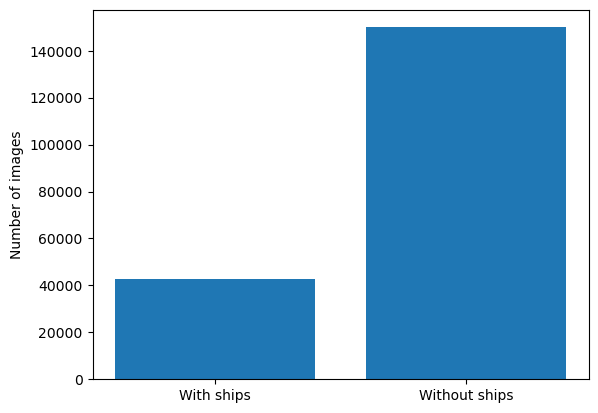

Number of images with ships : 42556 | Number of images without ships : 149999  (x3.5)


In [20]:
df_wships = masks.dropna()
df_wships = df_wships.groupby('ImageId').size().reset_index(name='counts')
df_woships = masks[masks['EncodedPixels'].isna()]

plt.bar(['With ships','Without ships'], [len(df_wships), len(df_woships)])
plt.ylabel('Number of images')
plt.show()

print('Number of images with ships : %d | Number of images without ships : %d  (x%0.1f)' \
      % (df_wships.shape[0], df_woships.shape[0], df_woships.shape[0] / df_wships.shape[0]))

In [11]:
data = pd.read_csv(masks_path).fillna(-1)
image_name = 'c8b051d24.jpg'

image = get_image(image_name, train_image_path)
u_mask = get_united_masks(image_name, data)

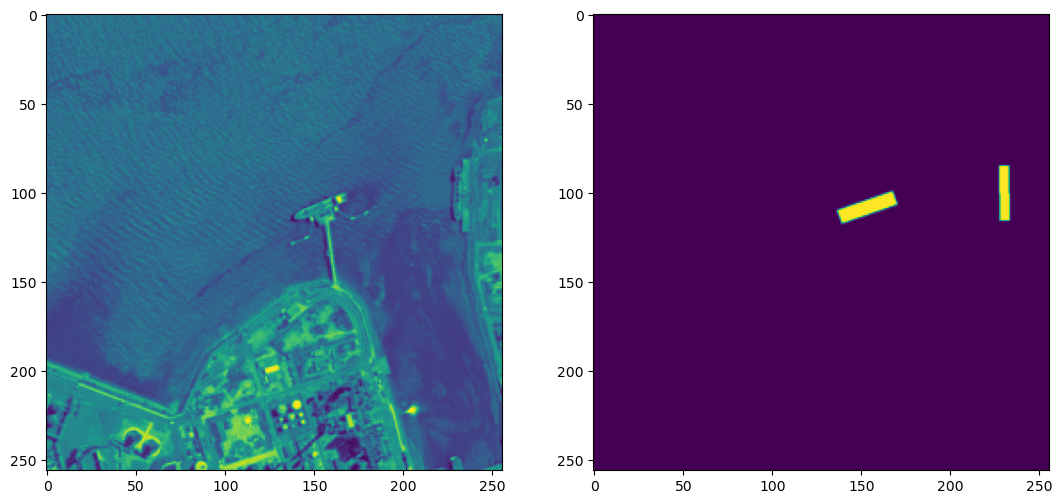

In [12]:
fig=plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 3, 1)
img = np.reshape(image, (256, 256))
plt.imshow(img)
ax = fig.add_subplot(1, 3, 2)
plt.imshow(u_mask)
plt.show()

## Data preparation

In [13]:
image_data = pd.read_csv(masks_path).dropna()
image_data = image_data.reset_index(drop=True)

images_name = image_data['ImageId']
images_name = images_name.drop_duplicates()
images_name = images_name.sample(frac=1)
print(f'Original images with data {images_name.shape}')

images_to_use, images_discarded = train_test_split(images_name, test_size=0.95)
print(f'After reducing the size {images_to_use.shape}')
train_df, test_df = train_test_split(images_to_use, test_size=0.3)
print(f'Training data shape: {train_df.shape}')
print(f'Test data shape: {test_df.shape}')

Original images with data (42556,)
After reducing the size (2127,)
Training data shape: (1488,)
Test data shape: (639,)


In [14]:
def get_dataset_X_y(chosen_image, full_dataset):
    X_data = []
    y_data = []
    for index, image_id in chosen_image.items():
        image = get_image(image_id, train_image_path)
        X_data.append(tf.convert_to_tensor(image / 255, dtype=tf.float32))
        masks = get_united_masks(image_id, full_dataset)
        y_data.append(tf.convert_to_tensor(masks, dtype=tf.bool))
    print('Converting to tensor')
    X_data = tf.convert_to_tensor(X_data)
    y_data = tf.convert_to_tensor(y_data)
    y_data = keras.utils.to_categorical(y_data, 2)
    print('End converting to tensor')
    return X_data, y_data

In [15]:
X_train, y_train = get_dataset_X_y(train_df, image_data)
X_test, y_test = get_dataset_X_y(test_df, image_data)

print(f'Shape of X  train {X_train.shape}')
print(f'Shape of y  train {y_train.shape}')

Converting to tensor
End converting to tensor
Converting to tensor
End converting to tensor
Shape of X  train (1488, 256, 256, 1)
Shape of y  train (1488, 256, 256, 2)


## Model

In [18]:
from keras.losses import binary_crossentropy

n_classes = 2

img_input = Input(shape=(256, 256, 1))

conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(img_input)
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D((2, 2))(conv1)

conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D((2, 2))(conv2)

conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D((2, 2))(conv3)

conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D((2, 2))(conv4)

conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)
up1 = concatenate([UpSampling2D((2, 2))(conv5), conv4], axis=-1)

conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up1)
conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)
up2 = concatenate([UpSampling2D((2, 2))(conv6), conv3], axis=-1)

conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up2)
conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)
up3 = concatenate([UpSampling2D((2, 2))(conv7), conv2], axis=-1)

conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up3)
conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)
up4 = concatenate([UpSampling2D((2, 2))(conv8), conv1], axis=-1)

conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up4)
conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)
conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)
conv9 = Conv2D(n_classes, (3, 3), activation='relu', padding='same')(conv9)

out = softmax(conv9)

model = keras.Model(inputs=img_input, outputs=out, name="AirbusCNN")

model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics = ['acc'])

Model: "AirbusCNN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_40 (Conv2D)             (None, 256, 256, 64  640         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_41 (Conv2D)             (None, 256, 256, 64  36928       ['conv2d_40[0][0]']              
                                )                                                         

#### We train the data model and see how slow the process is. My guess is that there is a connection between the updated package and system requirements. Therefore, I suggest that you look at the final results in a notebook with older versions of packages: ''Test task Winstars (OVP)''

In [19]:
history = model.fit(X_train, y_train,
              batch_size=32,
              epochs=15,
              shuffle=True,
              callbacks = [keras.callbacks.EarlyStopping(patience=5)],
              validation_data=(X_test, y_test))

Epoch 1/15
47/47 [==============================] - 6848s 146s/step - loss: 0.1734 - acc: 0.9714 - val_loss: 0.1154 - val_acc: 0.9925
Epoch 2/15
47/47 [==============================] - 6959s 148s/step - loss: 0.1131 - acc: 0.9926 - val_loss: 0.1154 - val_acc: 0.9925
Epoch 3/15
 3/47 [>.............................] - ETA: 1:37:47 - loss: 0.1112 - acc: 0.9928

KeyboardInterrupt: 

In [13]:
%pip list

Package                                Version        Editable project location
-------------------------------------- -------------- -------------------------
absl-py                                1.4.0
accelerate                             0.12.0
access                                 1.1.9
affine                                 2.4.0
aiobotocore                            2.5.0
aiofiles                               22.1.0
aiohttp                                3.8.4
aiohttp-cors                           0.7.0
aioitertools                           0.11.0
aiorwlock                              1.3.0
aiosignal                              1.3.1
aiosqlite                              0.19.0
albumentations                         1.3.1
alembic                                1.11.1
altair                                 5.0.1
annoy                                  1.17.2
ansiwrap                               0.8.4
anyio                                  3.6.2
apache-beam             